In [1]:
import sys
sys.path.append("..")
import thirdparty
from thirdparty import *
import transformers
from transformers import DetrImageProcessor, DetrForObjectDetection

In [2]:
def image_show(image,color_type="rgb",title="Example Image"):
    shape_info=image.shape
    if(image.dtype!=np.uint8):
        image = (image * 255).astype(np.uint8)
    if(shape_info[0] == 1 or shape_info[0] == 3):
        image = np.transpose(image, (1, 2, 0))
    if (color_type=="bgr"):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if (color_type=="gray"):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

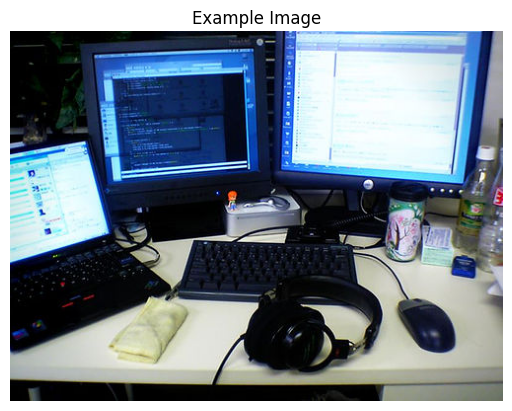

In [3]:
image = Image.open("/root/autodl-tmp/data/COCO/val_image/000000555009.jpg")#000000555412.jpg
image_show(np.array(image),"rgb")

In [4]:
print (type(image))
print(image)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7F04B586A160>


# 本地导入代码修改

# 导入模型

In [5]:
# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("/root/autodl-tmp/model/detr-resnet-50",revision="no_timm")
# model=torch.load("../model/detr-resnet-50/pytorch_model.bin")
model = DetrForObjectDetection.from_pretrained("/root/autodl-tmp/model/detr-resnet-50",revision="no_timm")
#图片进行-1~1的归一化，尺寸的归一化。。。
inputs = processor(images=image,return_tensors="pt")
outputs = model(**inputs)
print ("outputs:")
print (outputs.logits.shape)
print (outputs.pred_boxes.shape)
# shape为[:,100,:]，本身就是有N个物体通过FFN进行检测

Some weights of the model checkpoint at /root/autodl-tmp/model/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


outputs:
torch.Size([1, 100, 92])
torch.Size([1, 100, 4])


In [6]:
print(transformers.__file__)

/root/miniconda3/lib/python3.8/site-packages/transformers/__init__.py


In [7]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

In [8]:
image=np.array(image)

In [9]:
print(results)

{'scores': tensor([0.9510, 0.9992, 0.9907, 0.9982, 0.9968, 0.9816, 0.9887, 0.9973, 0.9984],
       grad_fn=<IndexBackward0>), 'labels': tensor([76, 74, 44, 72, 73, 44, 44, 76, 72]), 'boxes': tensor([[-1.4932e-01,  2.1640e+02,  1.6089e+02,  3.2629e+02],
        [ 3.9465e+02,  2.7161e+02,  4.5434e+02,  3.2525e+02],
        [ 4.7209e+02,  1.1792e+02,  4.9997e+02,  2.4915e+02],
        [ 7.0873e+01,  5.7225e+00,  2.6543e+02,  1.8773e+02],
        [-2.5786e-01,  1.0475e+02,  1.6391e+02,  3.2752e+02],
        [ 3.8031e+02,  1.5435e+02,  4.2372e+02,  2.3435e+02],
        [ 4.5189e+02,  1.1538e+02,  4.9219e+02,  2.3204e+02],
        [ 1.7062e+02,  2.1191e+02,  3.5229e+02,  2.7666e+02],
        [ 2.6782e+02,  8.3853e-02,  4.9544e+02,  1.7082e+02]],
       grad_fn=<IndexBackward0>)}


Detected keyboard with confidence 0.951 at location [0, 216, 160, 326]
Detected mouse with confidence 0.999 at location [394, 271, 454, 325]
Detected bottle with confidence 0.991 at location [472, 117, 499, 249]
Detected tv with confidence 0.998 at location [70, 5, 265, 187]
Detected laptop with confidence 0.997 at location [0, 104, 163, 327]
Detected bottle with confidence 0.982 at location [380, 154, 423, 234]
Detected bottle with confidence 0.989 at location [451, 115, 492, 232]
Detected keyboard with confidence 0.997 at location [170, 211, 352, 276]
Detected tv with confidence 0.998 at location [267, 0, 495, 170]


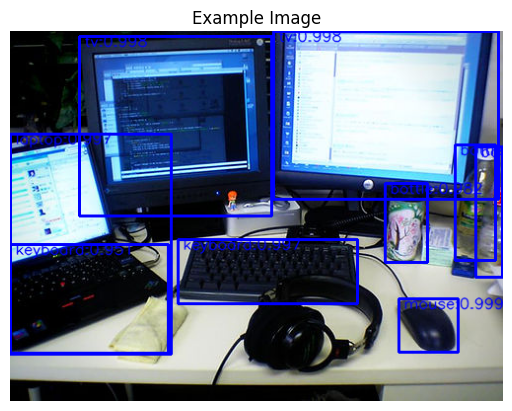

In [10]:
k = results['scores'].shape[0]
for i in range(k):
    #是个四维数组：左上角坐标，右下角坐标
    score, label, box = results['scores'][i],results['labels'][i],results['boxes'][i]
    box = [int(max(b,0)) for b in box.tolist()]
    p1=tuple(box[0:2])
    p2=tuple(box[2:4])
    cv2.rectangle(image, p1,p2, (0, 0, 255), 2)
    label_text=model.config.id2label[label.item()]
    text = "{}:{:.3f}".format(label_text,round(score.item(), 3))
    # 选择文字的起始位置，可以是矩形的左上角，也可以是矩形上方
    text_position = (p1[0]+5, p1[1] + 10)  # 在矩形上方显示文字
    # 在图像上写字
    cv2.putText(image, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 
            0.5, (0, 0, 255), 1, cv2.LINE_AA)
    print(
            f"Detected {label_text} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )
image_show(image,color_type="rgb",title="Example Image")